In [1]:
import VariationalBayes as vb
from VariationalBayes.SparseObjectives import SparseObjective, Objective
from VariationalBayes.Models.NormalMixture import normal_mixture as mix

import math

import autograd
import autograd.numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import time

from copy import deepcopy
import scipy as sp
from scipy import optimize
from scipy import stats

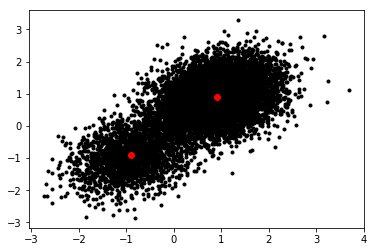

In [2]:
# Number of data points:
num_obs = 10000

# Dimension of observations:
d_num = 10

# Number of clusters:
k_num = 2

mu_scale = 3
noise_scale = 0.5

true_pi = np.linspace(0.2, 0.8, k_num)
true_pi = true_pi / np.sum(true_pi)

mu_prior_mean = np.full(d_num, 0.)
mu_prior_cov = np.diag(np.full(d_num, mu_scale ** 2))
mu_prior_info = np.linalg.inv(mu_prior_cov)
mu_spacing = np.linspace(-0.9, 0.9, k_num)
true_mu = np.array(np.tile(np.expand_dims(mu_spacing, axis=1), (k_num, d_num)))
true_sigma = np.array([ np.diag(np.full(d_num, noise_scale ** 2)) + np.full((d_num, d_num), 0.1) \
                        for k in range(k_num) ])
true_info = np.array([ np.linalg.inv(true_sigma[k, :, :]) for k in range(k_num) ])

x, true_z, true_z_ind = mix.generate_data(num_obs, true_mu, true_sigma, true_pi)

# visualize the dataz
plt.plot(x[:,0], x[:,1], 'k.')
for k in range(k_num):
    plt.plot(true_mu[k, 0], true_mu[k, 1], 'ro')

In [3]:
global_params = vb.ModelParamsDict('global')
global_params.push_param(
    vb.PosDefMatrixParamVector(name='info', length=k_num, matrix_size=d_num))
global_params.push_param(
    vb.ArrayParam(name='mu', shape=(k_num, d_num)))
global_params.push_param(
    vb.SimplexParam(name='pi', shape=(1, k_num)))

local_params = vb.ModelParamsDict('local')
local_params.push_param(
    vb.SimplexParam(name='e_z', shape=(num_obs, k_num),
                    val=np.full(true_z.shape, 1. / k_num)))

params = vb.ModelParamsDict('mixture model')
params.push_param(global_params)
params.push_param(local_params)

true_init = False
if true_init:
    params['global']['info'].set(true_info)
    params['global']['mu'].set(true_mu)
    params['global']['pi'].set(true_pi)
else:
    params['global']['mu'].set(np.random.random(params['global']['mu'].shape()))
    
init_par_vec = params.get_free()
global_init_par_vec = params['global'].get_free()

print(params['global'])

global:
	info:
[[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]

 [[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]]
	mu:
[[ 0.16491728  0.11846755  0.26781523  0.8832582   0.91265188  0.37543066
   0.51543053  0.30198

In [4]:
prior_params = vb.ModelParamsDict()
prior_params.push_param(vb.VectorParam(name='mu_prior_mean', size=d_num, val=mu_prior_mean))
prior_params.push_param(vb.PosDefMatrixParam(name='mu_prior_info', size=d_num, val=mu_prior_info))
prior_params.push_param(vb.ScalarParam(name='alpha', val=2.0))
prior_params.push_param(vb.ScalarParam(name='dof', val=d_num + 2.0))

In [5]:
model = mix.Model(x, params, prior_params)
kl_obj = Objective(model.params['global'], model.kl)

In [9]:
def minimize_kl(kl_obj, init_x, full_hessian=True, gtol=1e-8):
    if full_hessian:
        vb_opt = optimize.minimize(
            lambda par: kl_obj.fun_free(par, verbose=True),
            x0=init_x,
            jac=kl_obj.fun_free_grad,
            hess=kl_obj.fun_free_hessian,
            method='trust-ncg', options={'maxiter': 50, 'gtol': gtol})
    else:
        vb_opt = optimize.minimize(
            lambda par: kl_obj.fun_free(par, verbose=True),
            x0=init_x,
            jac=kl_obj.fun_free_grad,
            hessp=kl_obj.fun_free_hvp,
            method='trust-ncg', options={'maxiter': 50, 'gtol': gtol})

    print('done')
    return vb_opt

vb_opt = minimize_kl(kl_obj, global_init_par_vec, full_hessian=False)
print(kl_obj.fun_free(vb_opt.x))

Value:  52085.680807
Value:  29385.788317
Value:  14542.6344636
Value:  3644.41215663
Value:  937.855929373
Value:  -1984.96407608
Value:  -2889.38289495
Value:  -3378.83332335
Value:  -4124.96766628
Value:  -5038.14303941
Value:  -4725.62679453
Value:  -5410.36472739
Value:  -5890.92193178
Value:  -6176.18593535
Value:  -6221.03102328
Value:  -6243.59853317
Value:  -6244.50912291
Value:  -6244.62138478
Value:  -6244.64355847
Value:  -6244.64926149
Value:  -6244.64966156
Value:  -6244.64979347
Value:  -6244.64979801
Value:  -6244.64979913
Value:  -6244.64979936
Value:  -6244.64979936
Value:  -6244.64979936
Value:  -6244.64979936
done
-6244.64979936


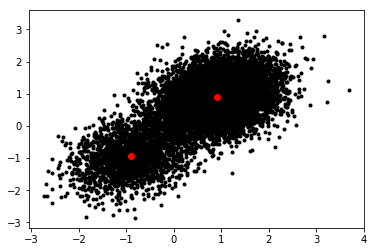

In [10]:
# Check that the solution looks sensible.
model.params['global'].set_free(vb_opt.x)
model.optimize_z()

mu_fit = model.params['global']['mu'].get()
plt.plot(x[:,0], x[:,1], 'k.')
for k in range(k_num):
    plt.plot(mu_fit[k, 0], mu_fit[k, 1], 'ro')

In [11]:
moment_jac = model.get_moment_jacobian(vb_opt.x)
kl_hessian = kl_obj.fun_free_hessian(vb_opt.x)
sensitivity_operator = np.linalg.solve(kl_hessian, moment_jac.T)
print('Hessian done.')

Hessian done.


In [12]:
# def loglik_obs_set_z(global_free_par, model):
#     model.params['global'].set_free(global_free_par)
#     model.optimize_z()
#     return model.loglik_obs()

# eval_loglik_obs_set_z_jac = autograd.jacobian(loglik_obs_set_z)
# weight_jac = eval_loglik_obs_set_z_jac(vb_opt.x, model)
# data_sens = np.matmul(weight_jac, sensitivity_operator)
# print(data_sens.shape)

In [23]:
# Somewhat surprisingly, this is much faster than differentiating the vector directly!

def loglik_obs_set_z_weights(global_free_par, weights, model):
    model.params['global'].set_free(global_free_par)
    model.optimize_z()
    model.weights = weights
    return model.loglik()

eval_global_grad = autograd.jacobian(loglik_obs_set_z_weights, argnum=0)
eval_weight_jac = autograd.jacobian(eval_global_grad, argnum=1)
weight_jac = eval_weight_jac(vb_opt.x, model.weights, model)
data_sens = np.matmul(weight_jac.T, sensitivity_operator)
x_data_sens = np.linalg.solve(kl_hessian, np.squeeze(weight_jac)).T
# print(data_sens.shape)

In [24]:
# Check sensitivity upon refitting with a new model with non-unity weights.
model_perturbed = deepcopy(model)
kl_obj_perturbed = Objective(model_perturbed.params['global'], model_perturbed.kl)

In [ ]:
# Bootstrap weights
perturbed_weights = \
    np.random.multinomial(num_obs, [1/float(num_obs)] * num_obs, size=1).T

refit_time = time.time()
model_perturbed.weights = perturbed_weights
perturbed_x_guess = \
    vb_opt.x + np.squeeze(np.matmul(perturbed_weights.T - 1.0, x_data_sens))
vb_opt_reweight = minimize_kl(kl_obj_perturbed, perturbed_x_guess, full_hessian=True)
model_perturbed.params['global'].set_free(vb_opt_reweight.x)
refit_time = time.time() - refit_time

Value:  -6229.53205597
Value:  -6229.68732509
Value:  -6229.72835483
Value:  -6229.73502144
Value:  -6229.73671875
Value:  -6229.73675093


Actual sensitivity:	 [-0.00723992  0.00668091  0.00437419  0.00410716  0.00048048 -0.00868561
  0.00978697  0.01574339 -0.00802635  0.02473903  0.00202413  0.00240111
 -0.00833893 -0.00427501 -0.00357468  0.0005411  -0.00502383  0.00317605
  0.00012455 -0.00065734]
Predicted sensitivity:	 [-0.00642726  0.00714878  0.00515313  0.00444068  0.0012409  -0.00797095
  0.01084706  0.01635734 -0.00686788  0.02559061  0.00226554  0.0027699
 -0.00802986 -0.00386722 -0.00327924  0.00081012 -0.00477752  0.00352961
  0.00028769 -0.00033307]
Refit time:	 71.7113606929779
Linear time:	 0.0011982917785644531


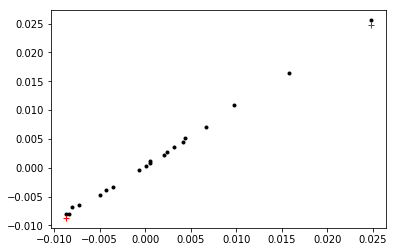

In [32]:
actual_sens = model_perturbed.get_interesting_moments(vb_opt_reweight.x) - \
      model.get_interesting_moments(vb_opt.x)
lin_time = time.time()
pred_sens = np.squeeze(np.matmul(perturbed_weights.T - 1.0, data_sens))
lin_time = time.time() - lin_time
    
print('Actual sensitivity:\t', actual_sens)
print('Predicted sensitivity:\t', pred_sens)

# Of course, re-optimizing takes almost all the time.
print('Refit time:\t', refit_time)
print('Linear time:\t', lin_time)

plt.plot(actual_sens, pred_sens, 'k.')
plt.plot(np.max(actual_sens), np.max(actual_sens), 'r+')
plt.plot(np.min(actual_sens), np.min(actual_sens), 'r+')